# Explore implementation of FCN model

In [18]:
from src.data.pipelines import fcn_pipeline
from src.models import fcn

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow_datasets as tfds

import src.data.datasets.deep_globe_2018

## Reuse code from previous notebooks

In [4]:
IMAGE_SIZE = 224
BATCH_SIZE = 1
SPLIT_TRAIN = ':100'
SPLIT_VALID = '10:20'
SPLIT_TEST = '20:30'

In [8]:
(train, valid, test) = fcn_pipeline.getFCNPipeline(
    SPLIT_TRAIN,
    SPLIT_VALID,
    SPLIT_TEST,
    BATCH_SIZE,
    IMAGE_SIZE
)

In [9]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    print(len(display_list))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i][0]))
        plt.axis('off')
    plt.show()

## Explore model

In [10]:
fcn_32s = fcn.get_fcn_32s()

In [27]:
CHECKPOINT_DIR = os.path.join(os.getcwd(),'..', 'models', 'ckpt', 'fcn_32s')
latest = tf.train.latest_checkpoint(CHECKPOINT_DIR)
fcn_32s.load_weights(latest)

In [28]:
fcn_32s.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [15]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = [loss,
           tf.keras.metrics.MeanIoU(num_classes=7)]
fcn_32s.compile(optimizer=opt, loss=loss, metrics=metrics)

In [17]:
fcn_32s.fit(
    train_batches,
    epochs=1
)

5/5 [==============================] - 44s 7s/step - loss: 1.9474 - categorical_crossentropy: 1.9474 - mean_io_u_1: 0.4286


In [30]:
def one_hot_to_rgb(one_hot_map):
    palette = [
        [0, 255, 255],   # urban_land
        [255, 255, 0],   # agriculture_land
        [255, 0, 255],   # rangeland
        [0, 255, 0],     # forest_land
        [0, 0, 255],     # water
        [255, 255, 255], # barren_land
        [0, 0, 0]        # unknown
    ]

    one_hot_map = tf.cast(one_hot_map, tf.int32)
    # Use one-hot map and palette to reconstruct RGB image
    reconstructed_image = tf.reduce_sum(tf.expand_dims(one_hot_map, axis=-1) * tf.constant(palette), axis=-2)

    return tf.cast(reconstructed_image, dtype=tf.uint8)

1/1 [==============================] - 1s 903ms/step
3


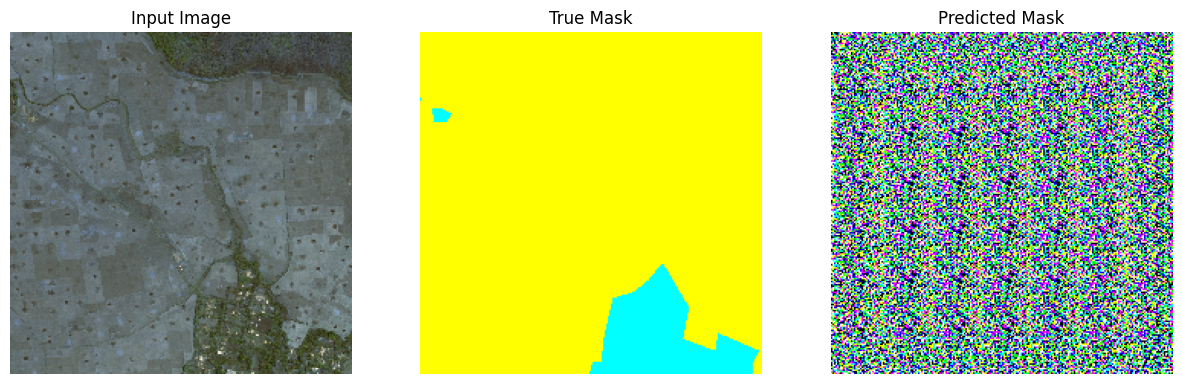

1/1 [==============================] - 0s 474ms/step
3


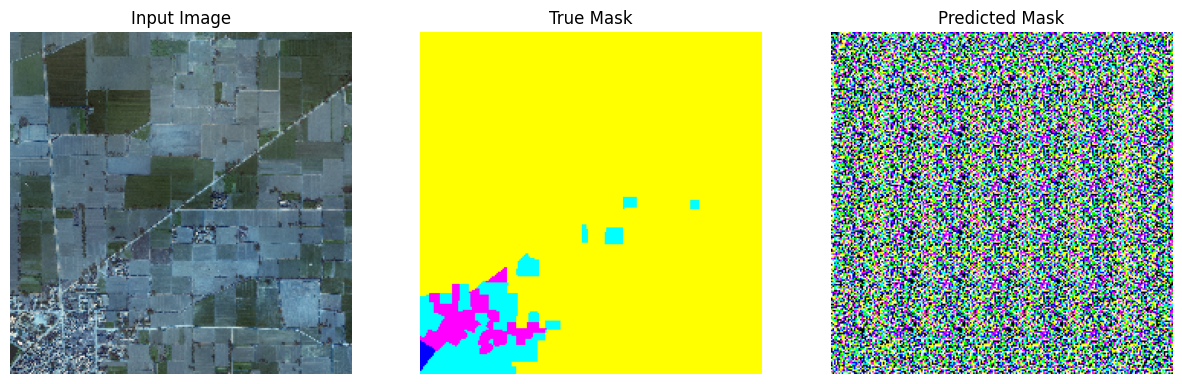

1/1 [==============================] - 0s 443ms/step
3


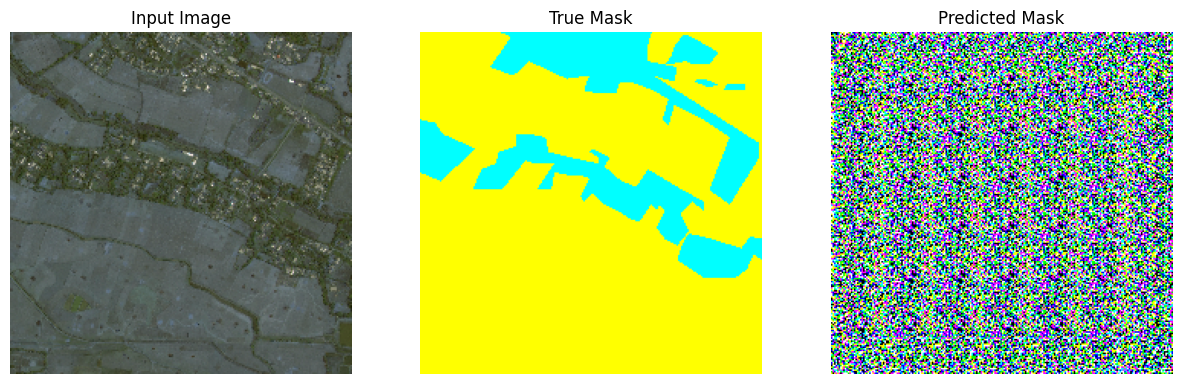

1/1 [==============================] - 0s 388ms/step
3


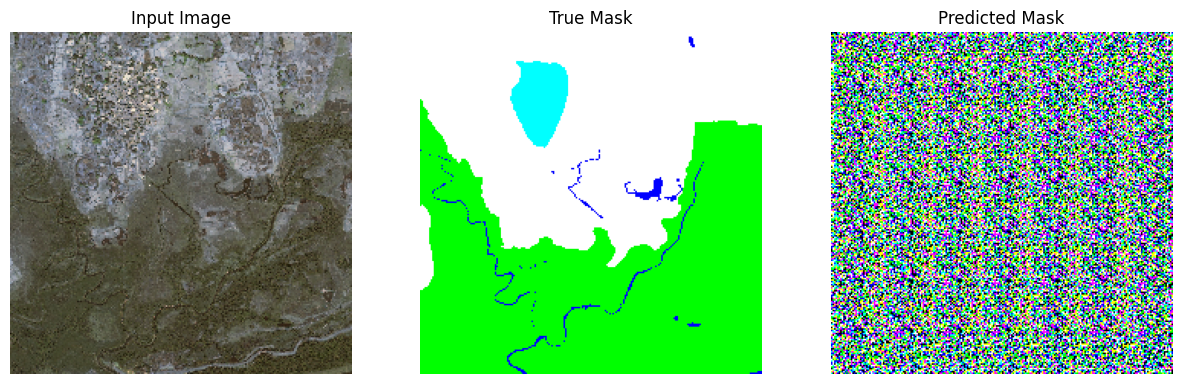

In [31]:
for i, m in train.take(10):
    y = fcn_32s.predict(i)
    y_one_hot = tf.one_hot(tf.argmax(y, axis = 3), depth = 7)
    mask_gt = one_hot_to_rgb(m)
    mask_pred = one_hot_to_rgb(y_one_hot)
    display([i, mask_gt, mask_pred])